# Assignment Lab 9 - Nicolas Duboc

## packages and imports: 
includes data download as well as annular_avg and graph_spectrum from ubc_fft class found in lab 9

In [1]:
# packages and data imports 
import numpy as np 
import matplotlib.pyplot as plt
import urllib
import os  
from netCDF4 import Dataset
filelist=['miami_tower.npz','a17.nc','aircraft.npz']
data_download=True
if data_download:
    for the_file in filelist:
        url='http://clouds.eos.ubc.ca/~phil/docs/atsc500/data/{}'.format(the_file)
        urllib.request.urlretrieve(url,the_file)
        print("download {}: size is {:6.2g} Mbytes".format(the_file,os.path.getsize(the_file)*1.e-6))

import warnings
warnings.filterwarnings("ignore")

# useful functions from lab9
def annular_avg(spectral_dens, avg_binwidth, xdim, midpoint):
    """
    integrate the 2-d power spectrum around a series of rings
    of radius kradial and average into a set of 1-dimensional
    radial bins
    """
    #
    #  define the k axis which is the radius in the 2-d polar version of E
    #
    numbins = int(round((np.sqrt(2)*xdim/avg_binwidth),0)+1)

    avg_spec = np.zeros(numbins,np.float64)
    bin_count = np.zeros(numbins,np.float64)

    print("\t- INTEGRATING... ")
    for i in range(xdim):
        # if (i%100) == 0:
        #     print("\t\trow: {} completed".format(i))
        for j in range(xdim):
            kradial = np.sqrt(((i+1)-xdim/2)**2+((j+1)-xdim/2)**2)
            bin_num = int(np.floor(kradial/avg_binwidth))
            avg_spec[bin_num]=avg_spec[bin_num]+ kradial*spectral_dens[i,j]
            bin_count[bin_num]+=1

    for i in range(numbins):
        if bin_count[i]>0:
            avg_spec[i]=avg_spec[i]*avg_binwidth/bin_count[i]/(4*(np.pi**2))
    
    #
    # dimensional wavenumbers for 1-d average spectrum
    #
    k_bins=np.arange(numbins)+1
    k_bins = k_bins[0:midpoint]
    avg_spec = avg_spec[0:midpoint]

    return k_bins, avg_spec

def graph_spectrum(k_bins,avg_spec,kol_slope=-5./3., kol_offset=1., \
                      title=None):
    """
       graph the annular average and compare it to Kolmogorov -5/3
    """

    delta_k = 1./scale                # 1./km (1/0.025 for landsat 25 meter pixels)
    nyquist = delta_k * 0.5
    knum = k_bins * (nyquist/float(len(k_bins)))# k = w/(25m)
    #
    # draw the -5/3 line through a give spot
    #
    kol = kol_offset*(knum**kol_slope)
    fig,ax=plt.subplots(1,1,figsize=(8,8))
    ax.loglog(knum,avg_spec,'r-',label='power')
    ax.loglog(knum,kol,'k-',label="$k^{-5/3}$")
    ax.set(title=title,xlabel='k (1/km)',ylabel='$E_k$')
    ax.legend()


download miami_tower.npz: size is    1.5 Mbytes
download a17.nc: size is     17 Mbytes
download aircraft.npz: size is   0.73 Mbytes


In [2]:
# get a17.nc data - from the ubc_fft class 
with Dataset('a17.nc','r') as fin:
    data = fin.variables['tau'][...]
data = data - data.mean()
xdim = data.shape[0]
midpoint = int(np.floor(xdim/2))
scale = 0.025 # 25m in each pixel

# Problem -- lowpass filtering of a 2-d image

## part 1 - low-pass filtered image

Text(0.5, 1.0, 'Original Landsat a17')

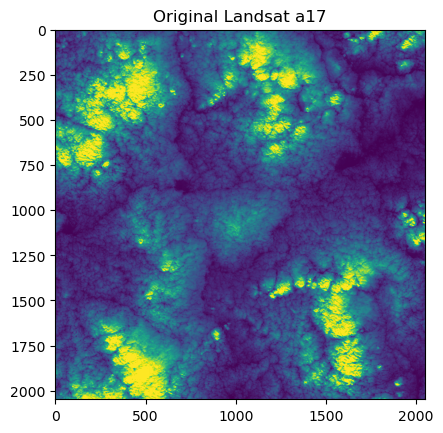

In [3]:
fig, ax = plt.subplots(1,1)
ax.imshow(data)
ax.set_title('Original Landsat a17')

In [4]:
data_fft = np.fft.fftshift(np.fft.fft2(data))
spec_dens = data_fft*np.conj(data_fft)/xdim**2
spec_dens = spec_dens.real
N = int(data_fft.shape[0]/2) # same for both since its square
nyq = 20 # 40px/km -> nyquist is 20px/km
wnPerbin = nyq/N
n = np.arange(-20,20,wnPerbin) # centered axes 


# now create a square that whose points are (1,1), (1,-1), (-1,-1), (-1,1)
oneKm = np.where(abs(n)<1)[0]
sqrFilt = np.zeros_like(data_fft)
sqrFilt[oneKm,:] = 1
zeroOut = np.where(abs(n)>1)[0]
sqrFilt[:,zeroOut] = 0

data_fft_filt = data_fft*sqrFilt
spec_dens_filt = data_fft_filt*np.conj(data_fft_filt)/xdim**2

rec_fdata = np.real(np.fft.ifft2(np.fft.ifftshift(data_fft*sqrFilt)))


Text(0.5, 1.0, '2D filter function @ $1km^{-1}$')

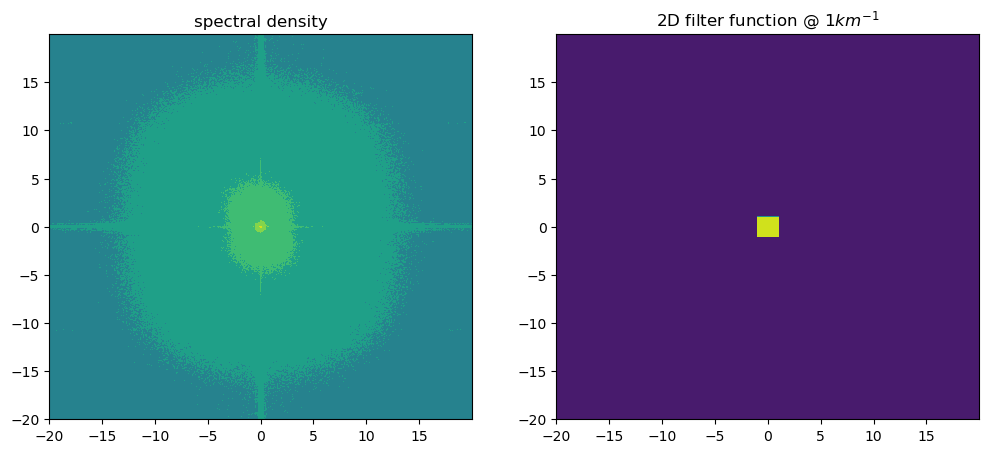

In [5]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
ax1.contourf(n,n,np.log(spec_dens))
ax1.set_title('spectral density')

ax2.contourf(n,n,sqrFilt)
ax2.set_title('2D filter function @ $1km^{-1}$')

Text(0.5, 1.0, 'reconstructed filtered landsat a17')

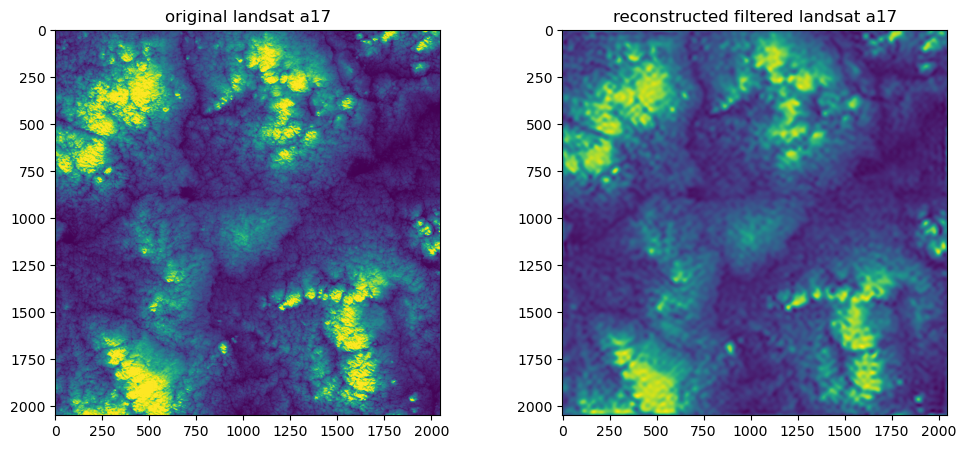

In [6]:
fig,(ax3,ax4) = plt.subplots(1,2,figsize=(12,5))
ax3.imshow(data)
ax3.set_title('original landsat a17')

ax4.imshow(rec_fdata)
ax4.set_title('reconstructed filtered landsat a17')

## part 2 - 1-d fft power spectrum

	- INTEGRATING... 


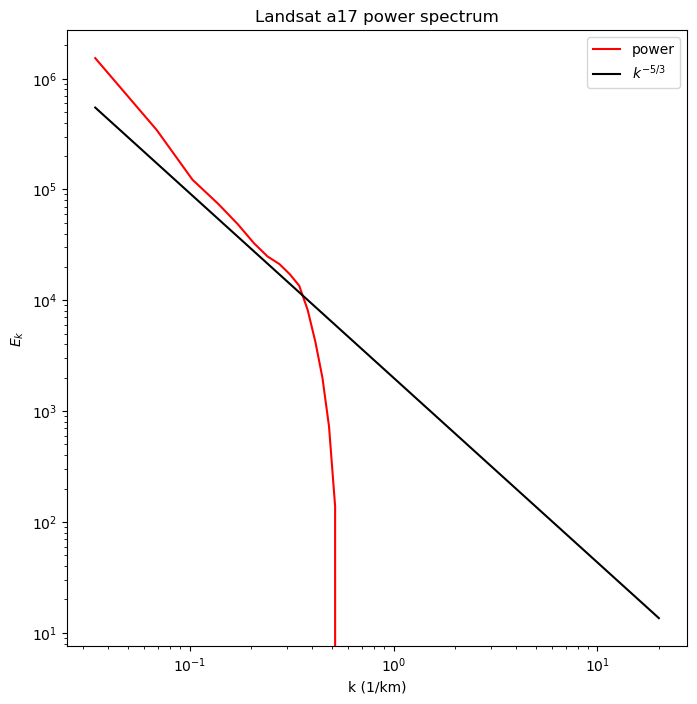

In [7]:
k_bins, avg_spec = annular_avg(spec_dens_filt,5,xdim,midpoint) #kradial bins 5 pixels wide
graph_spectrum(k_bins,avg_spec,kol_offset=2000.,title='Landsat a17 power spectrum')